#Embedding, LSTM, GRU and Conv1D
Cognitive Systems for Health Technology Applications
8.3.2019, Sakari Lukkarinen
Helsinki Metropolia University of Applied Sciences

Objectives
The aim of this Notebook is to show how to use keras embedding layers together with LSTM, GRU and Conv1D layers to classify review converted to sequences.

The examples are following the structure given in book: Chollet, Deep Learning with Python, Ch. 6. Deep learning for text and sequences. The examples are not optimized but the aim is to show how to configure the model architectures.

#Data preparation

In [37]:
# Import librarys what are needed in this case3
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Embedding, LSTM, Bidirectional, Dropout

from keras.preprocessing import sequence
from keras.models import Sequential

#For CNN
from keras.layers import Conv1D, Activation, MaxPooling1D, Dropout, Flatten, Dense
from keras import optimizers

import os
print(os.listdir("../../case3_datas"))


['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


In [38]:
# Create dataframes train and test
test = pd.read_csv(r"../../case3_datas/drugsComTest_raw.csv")
train = pd.read_csv(r"../../case3_datas/drugsComTrain_raw.csv")
train.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [39]:
test.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,3-Jul-14,13
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,21-Apr-09,32
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,18-Oct-16,21
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3


In [40]:
print("Training data shape:", train.shape)
print("Test data shape:", test.shape)

Training data shape: (161297, 7)
Test data shape: (53766, 7)


In [41]:
# Create labels based on the original article: Grässer et al. (2018)
r = train['rating']
labels = -1*(r <= 4) + 1*(r >= 7)
# Add the label column to the data
train['label'] = labels
# Check the new data
train.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,-1
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,-1
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,1
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11,-1
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,1


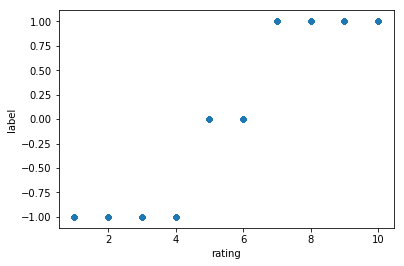

In [42]:
# Check ratings to labels conversion
import matplotlib.pyplot as plt
train.plot(x = 'rating', y = 'label', kind = 'scatter')
plt.show()


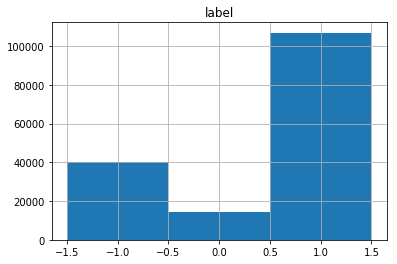

In [43]:

# Plot distribution of labels
train.hist(column = 'label', bins = np.arange(-1, 3), align = 'left');

# Convert reviews to padded sequences

In [44]:

# Read a part of the reviews and create training sequences (x_train)
samples = train['review'].iloc[:10000]
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
x_train = pad_sequences(sequences, maxlen = 500)

# Convert labels to one-hot-categories

In [45]:

# Convert the labels to one_hot_category values
one_hot_labels = to_categorical(labels[:10000], num_classes = 3)

# Check the shapes

In [46]:
# Check the training and label sets
x_train.shape, one_hot_labels.shape

((10000, 500), (10000, 3))

In [47]:
print(one_hot_labels)
print(" ")
print(x_train)

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
 
[[  0   0   0 ...  97 148   2]
 [  0   0   0 ...   3 202 332]
 [  0   0   0 ... 371  10  24]
 ...
 [  0   0   0 ... 152   4   7]
 [  0   0   0 ...  11 107 661]
 [  0   0   0 ...  88 220 462]]


In [48]:
# We use the same plotting commands several times, so create a function for that purpose
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [49]:
# Similarly create a function for model training, for demonstration purposes we use constant values
def train_model(model, x, y, e = 5, bs = 32, v = 1, vs = 0.25):
    h = model.fit(x, y, epochs = e, batch_size = bs, verbose = v, validation_split = vs)
    return h

In [50]:

# First model: Embedding layer -> Flatten -> Dense classifier
m0 = Sequential()
m0.add(Embedding(1000, 64, input_length = 500)) # 1000 = num_words, 64 = Embedding layers, 500 = sequence length
m0.add(Flatten())
m0.add(Dense(32, activation = 'relu'))
m0.add(Dense(3, activation = 'softmax'))
m0.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 64)           64000     
_________________________________________________________________
flatten_8 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1024032   
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 99        
Total params: 1,088,131
Trainable params: 1,088,131
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Train the first model and plot the history
#h0 = train_model(m0, x_train, one_hot_labels)
#plot_history(h0)

# Model nro.2 using CNN

In [52]:
#test = pd.read_csv(r"../../case3_datas/drugsComTest_raw.csv")
#train = pd.read_csv(r"../../case3_datas/drugsComTrain_raw.csv")

#training_data = (directory = "../../case3_datas/",
 #                                               dataframe = train,
  #                                              target_size = (64, 64),
   #                                             batch_size = 32,
    #                                            x_col = "review", 
     #                                           y_col = "labels",
      #                                          has_ext = False,
       #                                         class_mode = 'binary')


#test_data = flow_from_dataframe(
 #                                               dataframe = test,
  #                                              directory = "../../case3_datas/",
   #                                             target_size = (64, 64),
    #                                            batch_size = 32,
     #                                           x_col = "review", 
      #                                          y_col = "labels",
       #                                         has_ext = False,
        #                                        class_mode = 'binary')

In [53]:
# Lets Create a basic Sequential model with several Conv1D layers
model = Sequential()

model.add(Embedding(1600, 32, input_length = 500))
model.add(Conv1D(32, (3), activation = 'relu', input_shape = (161297, 7)))
model.add(Conv1D(32, (3), activation = 'relu'))
model.add(MaxPooling1D(pool_size = (2)))
model.add(Dropout(0.25))

model.add(Conv1D(64, (3), activation = 'relu'))
model.add(Conv1D(64, (3), activation = 'relu'))
model.add(MaxPooling1D(pool_size = (2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

# Try a custom metrics, needs to be calculated in backend (Tensorflow)  
from keras import backend
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd,
             loss='categorical_crossentropy', 
              metrics = ["accuracy", "mse", rmse])

infoa = """ All possible options for model.compile
For more details, see: https://keras.io/models/model/
model.compile( 
    optimizer, 
    loss = None, 
    metrics = None, 
    loss_weights = None, 
    sample_weight_mode = None, 
    weighted_metrics = None,
    target_tensors = None)
"""
#STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
#STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
#h000 = model.fit(x_train,
#            validation_data = [x_train, y_test],
 #           validation_steps = 15, #STEP_SIZE_VALID,
  #          epochs = 4,
 #           verbose = 2)
#plot_history(h000)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 32)           51200     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 498, 32)           3104      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 496, 32)           3104      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 248, 32)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 248, 32)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 246, 64)           6208      
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 244, 64)           12352     
__________

# Here we TRAIN the CNN model

Train on 7500 samples, validate on 2500 samples
Epoch 1/5
7500/7500 [==============================] - 43s 6ms/step - loss: 0.8622 - acc: 0.6573 - mean_squared_error: 0.1697 - rmse: 0.3797 - val_loss: 0.8469 - val_acc: 0.6560 - val_mean_squared_error: 0.1663 - val_rmse: 0.3696
Epoch 2/5
7500/7500 [==============================] - 38s 5ms/step - loss: 0.8413 - acc: 0.6588 - mean_squared_error: 0.1652 - rmse: 0.3710 - val_loss: 0.8490 - val_acc: 0.6560 - val_mean_squared_error: 0.1668 - val_rmse: 0.3627
Epoch 3/5
7500/7500 [==============================] - 41s 5ms/step - loss: 0.8415 - acc: 0.6588 - mean_squared_error: 0.1653 - rmse: 0.3700 - val_loss: 0.8467 - val_acc: 0.6560 - val_mean_squared_error: 0.1662 - val_rmse: 0.3722
Epoch 4/5
7500/7500 [==============================] - 40s 5ms/step - loss: 0.8410 - acc: 0.6588 - mean_squared_error: 0.1652 - rmse: 0.3707 - val_loss: 0.8477 - val_acc: 0.6560 - val_mean_squared_error: 0.1665 - val_rmse: 0.3655
Epoch 5/5
7500/7500 [===========

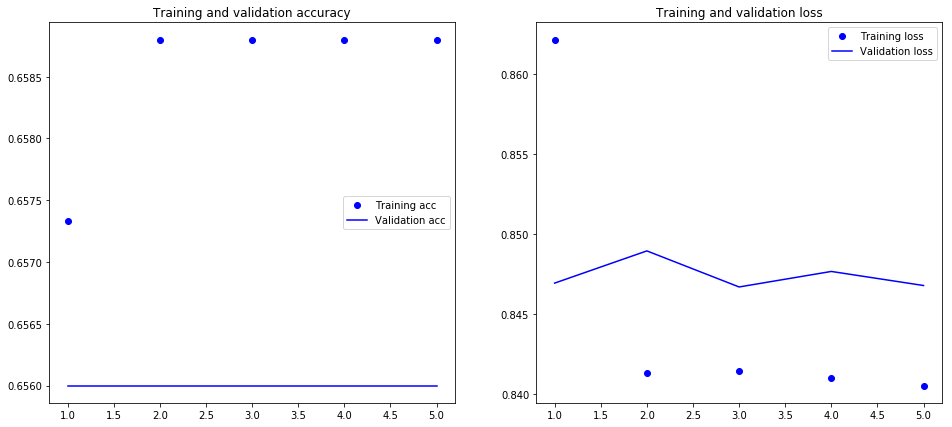

In [54]:
h1 = train_model(model, x_train, one_hot_labels)
plot_history(h1)

# Lets plot the train

In [55]:
# PLOTTING GOMING RIGHT UP! 
plot_history(h1)

# Model nro.3 

In [56]:

max_features = 1000 # Cut texts after this number of words. Thougs in this case, it is not needed...
maxlen = 500
batch_size = 32

print('Loading data...')

print(len(x_train), "train sequences")
print(len(x_test), "test sequences")

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

y_train = np.array(y_train)
y_test = np.array(y_test)

model2 = Sequential()
model2.add(Embedding(max_features, batch_size, input_length=maxlen))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation="sigmoid"))
model2.add(Dense(32, activation = 'relu'))

model2.summary()
# try using different optimizers and different optimizer configs
model2.compile("adam", "binary_crossentropy", metrics=["accuracy"])
print(" ")
print("Train...")
model2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

Loading data...
10000 train sequences


NameError: name 'x_test' is not defined

# Training of CNN model2

In [ ]:
# Train the first model and plot the history
h1 = train_model(model2, x_train, one_hot_labels)
plot_history(h1)